In [1]:
#使うライブラリ
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as pplot
from dataset.mnist import load_mnist

# データセットの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 4. ニューラルネットワークの学習

Let's study neural network! ではなくニューラルネットワークにデータを与えて学習させるほう。

## 4.1関連：特徴量という考え方

[特徴量とは、一言で表すと、分析対象データの中の、予測の手掛かりとなる変数のことです。](https://www.sbbit.jp/article/cont1/76066)  
また、データの何を変数として（特徴量として）使って機械学習を行おうかと、学習するためにデータを加工していく作業を特徴量エンジニアリング（feature engineering）ともいう。例えばデータセットの中に変数A,変数B,変数Cがあるとして、全てを機械学習アルゴリズムにかけるか、あるいはAとBだけというように一部だけ使うか、あるいは新たな変数を作るか（A＋BーC＝D的な）といった選択を行い、より精度の良いモデルを作ること。  
  
一般的な機械学習はデータ→特徴量を決める（特徴量エンジニアリング）→形の変わったデータ→機械学習の流れで行われる（粗い理解）。その一方でディープラーニングではその特徴量エンジニアリングがいらない。データをそのまま入力すると勝手にノードの重み（特徴量）を調整する。すごい。

## 4.2 損失関数

最適な重みパラメーターの探索のために用いられる関数。主に2乗和誤差や交差エントロピー誤差が用いられる。損失関数を使ってモデルの予測が教師データとどれだけズレているかを算出し、そのズレを小さくしていくことがニューラルネットワークの学習になる。

### 2乗和誤差

以下の計算でエラー(E)を求める。1/kをかけることもあるが、1/2とテキストでは記載されている。誤植ではなく[微分をしやすくするためらしい。](https://canplay-music.com/2019/06/02/loss-function/)  
$$
E = \frac{1}{2}\sum_{k}(y_k - t_k)^2
$$

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
# 例

##　yはニューラルネットからのソフトマックス関数を使っての出力のサンプル。1桁の数字の識別タスクと家庭。

## 正解ラベルのワンホットベクトルでの表現。「２」が正解のベクトル。
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

## ２を予測（せいかい）するベクトル。
y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
## 7を予測（まちがい）するベクトル
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

# 正解を予測できている場合
print("正解の予測の二乗和誤差の値")
print(mean_squared_error(np.array(y1), np.array(t)))
print()
print("間違いの予測の二乗和誤差の値")
print(mean_squared_error(np.array(y2), np.array(t)))



正解の予測の二乗和誤差の値
0.09750000000000003

間違いの予測の二乗和誤差の値
0.5975


上記のように、正解を出力できる方が間違いを出力する場合よりも二乗和誤差の数字が小さくなる。教師データ(t)により適合していることを示している。

### 交差エントロピー誤差

以下の計算で誤差（E）を求める。logの底は自然対数。
$$
E = -\sum_kt_k\log y_k
$$
ここで、tは正解ラベルのワンホット表現（正解のインデックス以外は0）なので、実際は正解のインデックスに対応する出力の自然対数を計算する関数となっている。$\log 1$は0なのでドンピシャに予測できると誤差がゼロになる。予測の確率が1より低くなると-で数値が大きくなる。たとえば$\log 0.5$はおよそ-0.69で$\log 0.1$はおよそ-2.3。マイナスを取るために総和のあとで-1がかけられている。

In [4]:
# 実装
def cross_entropy_error(y, t):
    delta = 1e-7 # log 0を割けるために微小な数字を計算時に足す
    return -np.sum(t * np.log(y + delta))

In [5]:
# 例

##　yはニューラルネットからのソフトマックス関数を使っての出力のサンプル。1桁の数字の識別タスクと家庭。

## 正解ラベルのワンホットベクトルでの表現。「２」が正解のベクトル。
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

## ２を予測（せいかい）するベクトル。
y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
## 7を予測（まちがい）するベクトル
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

# 正解を予測できている場合
print("正解の予測の交差エントロピー誤差の値")
print(cross_entropy_error(np.array(y1), np.array(t)))
print("間違いの予測の交差エントロピー誤差の値")
print(cross_entropy_error(np.array(y2), np.array(t)))


正解の予測の交差エントロピー誤差の値
0.510825457099338
間違いの予測の交差エントロピー誤差の値
2.302584092994546


二乗和誤差のときと同様に、間違いの予測の値のほうが大きくなっているのがわかる。

### 4.2.3ミニバッチ学習

大量にある訓練データをある程度のまとまり（ミニバッチ）にしてそれをひとまとまりとして、ミニバッチごとに損失関数を計算する。
これまで見てきた実装だとデータを一つ見て損失関数を計算していたが、ミニバッチだと大きな数のデータ（例えば100個とか）の損失関数を一度に計算するので、一つ一つ計算するよりも早い。  
なお、一つずつ訓練データを使って損失関数を計算する手法をオンライン学習（Udemyではない）という。逆にすべての訓練データを使っていっぺんに損失関数を計算する手法をバッチ学習（ミニではない）という。ミニバッチ学習はバッチ学習とオンライン学習の中間のイメージ。

In [6]:
#　ミニバッチ学習（たとえば100個纏めて計算）出来るように交差エントロピー誤差の実装を変える

def cross_entropy_error(y, t):
    #データセットが一つだけの時に1次元から2次元に変形する必要がある。
    if y.dim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

## 4.3 微分

微分とはある瞬間の変化量を表すもの。  

### 数値微分
まずは数値微分（numerical differentiation）を実装する。数値微分は導関数$\frac{df(x)}{dx} = \lim_{h \to 0}\frac{f(x + h) - f(x)}{h}$のhに実際に小さい数字を入れて計算を行う微分を求めること。以下の実装は中心差分と呼ばれる方法で実装していて、上記の導関数の式とは少し異なる。  

In [7]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2*h)

実際に試すために関数を一つ作る。

In [8]:
def function_1(x):
    return 0.01*x**2 + 0.1 * x

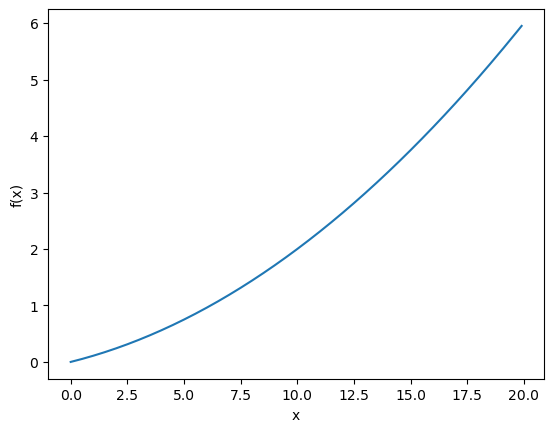

In [9]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [10]:
#この関数を微分する
numerical_diff(function_1, 5)

0.1999999999990898

↑上記の関数を解析的に微分すると$0.02x+0,1$になり、xが5のときに0.2になるので誤差はほぼ出ない。

### 偏微分

$f(x, y) = 3x + 2y$ のような、変数を複数持つ関数を多変数関数という。この関数だと$x$と$y$の2つの変数を持つ。このような関数のどちらか一つの変数に注目し、残りの変数を定数と見做して微分を計算することを偏微分という。  

実際にテキストに倣って以下の多変数関数を実装して偏微分をしてみる。  
$$
f(x_0, x_1) = x_0^2 + x_1^2
$$
テキストのような局面の描画はmeshgridを使ってぞれぞれの変数を2次元にして、plot_wireframeできるらしい[（参考）](https://tech-market.org/matplotlib-3d/)

In [11]:
def function_2(x):
    # 引数にNumPy配列が入力されることを想定。
    return x[0]**2 + x[1]**2

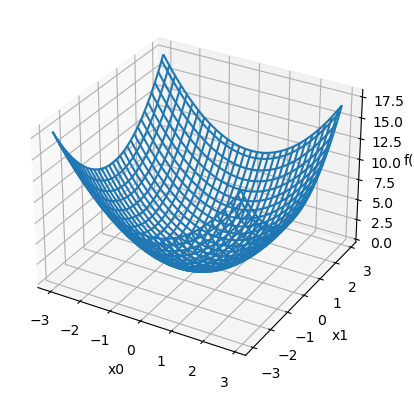

In [13]:
# テキストにあるような描画をしたい！
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)

X, Y = np.meshgrid(x, y)
z = function_2(np.array([X,Y]))

fig = pplot.figure()
ax = fig.add_subplot(projection = "3d")

ax.plot_wireframe(X,Y,z, cmap= "terrain")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("f(x)")

pplot.show()
# なんかz軸のラベル切れてない？画像サイズの問題っぽい。今回の本題でないのでそのままにしておく。

$x_0 = 3, x_1 = 4$のときの偏微分を計算する

In [16]:
#x0について偏微分をしてみる。
#変数の一つを定数と見做して微分をするのでここではx1を定数としてfunction_tmp1を定義する。

def function_tmp1(x0):
    return x0*x0 + 4.0 ** 2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

ちなみに解析的に$y = x_0^2 + x_1^2$を$x_0$について偏微分すると、$y' = 2x_0$になるので、$x_0 = 3$のとき$y' = 6$になる。

## 4.4 勾配

前述の2変数の関数だと$x_0$についての偏微分と$x_1$についての偏微分で、偏微分の実施の仕方が２つ存在する。つまり$\cfrac{\partial f}{\partial x_0}$と$\cfrac{\partial f}{\partial x_1}$の二つが偏微分としてある。この二つをベクトルとして格納したものを勾配と呼ぶ。勾配を計算する関数を実装する。

In [20]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x) #idxのほうのxだけh分増えている=他は固定している
        
        # f(x-h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

先に実装したfunction_2でこの勾配の実装を試してみる。

In [21]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

勾配が何を意味しているか。一変数の関数での微分はその関数のその点での傾きを表している、偏微分をベクトルにしている勾配も同様にそれぞれの変数ごとの傾きを表している。比喩的には、特定の関数のその地点での斜面の形状を表していると言える。  

さらに比喩的に言うと、目をつぶって山を登る（あるいは山を下るときも同じ）ことを考える。情報は足裏から感じる斜面の傾きだけになるので、その斜面の「感じ」を活かして登山（下山）をすることになる。それがこれから出てくる勾配降下法になる。